# 탐색한 데이터로 모델성능 개선

주피터 노트북 단축키
- 아래 셀과 합치기 : shift + m 
- 커서에서 셀 나누기 : shift + ctrl + - 
- 셀 다시 실행: ctrl +y
- 실행 취소: ctrl + z

전처리는 EDA를 먼저 해보고 하는 것이 좋다.

## 당뇨병 데이터셋 소개

캐글에서 제공하고 있는 피마인디언 당뇨병 데이터

https://www.kaggle.com/uciml/pima-indians-diabetes-database

- Pregnancies : 임신 횟수
- Glucose : 2시간 동안의 경구 포도당 내성 검사에서 혈장 포도당 농도
- BloodPressure : 이완기 혈압 (mm Hg)
- SkinThickness : 삼두근 피부 주름 두께 (mm), 체지방을 추정하는데 사용되는 값
- Insulin : 2시간 혈청 인슐린 (mu U / ml) / *0은 결측치*
- BMI : 체질량 지수 (체중kg / 키(m)^2)
- DiabetesPedigreeFunction : 당뇨병 혈통 기능
- Age : 나이
- Outcome : 768개 중에 268개의 결과 클래스 변수(0 또는 1)는 1이고 나머지는 0입니다.

## 필요한 라이브러리 로드

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 구버전 주피터 노트북 시각화 표시
# %matplotlib inline

## 데이터셋 로드

In [3]:
df = pd.read_csv('data/diabetes.csv')
df.shape

(768, 9)

In [4]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


전처리할 데이터 없다.
- 결측치, 문자가 섞여있으면 전처리가 필요하다

outcome이 예측할 데이터이다.

## Feature Engeering

Feature Engeering을 통해 신호와 소음을 찾아보자.

### 수치형 변수를 범주형 변수로 만들기

In [5]:
df['Pregnancies_high'] = df['Pregnancies']>6
df[['Pregnancies_high', 'Pregnancies']]

,Pregnancies_high,Pregnancies
0,False,6
1,False,1
2,True,8
3,False,1
4,False,0
...,...,...
763,True,10
764,False,2
765,False,5
766,False,1


In [6]:
# One-Hot-Encoding
# 수치 => 범주 => 수치
df['Age_low'] = df['Age'] < 30
df['Age_mid'] = (df['Age'] >= 30) & (df['Age']<=60)
df['Age_high'] = df['Age'] > 60
df[['Age','Age_low', 'Age_mid', 'Age_high']].head()

,Age,Age_low,Age_mid,Age_high
0,50,False,True,False
1,31,False,True,False
2,32,False,True,False
3,21,True,False,False
4,33,False,True,False


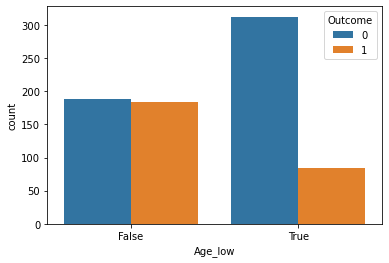

In [7]:
sns.countplot(data=df, x='Age_low', hue='Outcome')

Age_low인 경우 당뇨 발병율이 훨씬 적다.

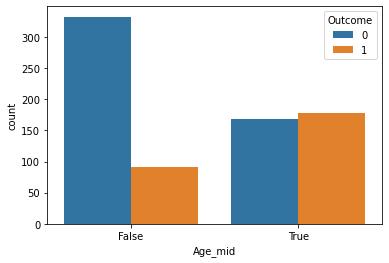

In [8]:
sns.countplot(data=df, x='Age_mid', hue='Outcome')

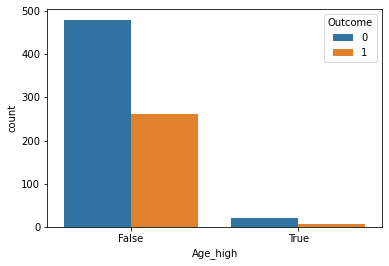

In [9]:
sns.countplot(data=df, x='Age_high', hue='Outcome')

Age_high인 당뇨병환자는 모수가 적다.

### 결측치 다루기

In [10]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
Pregnancies_high            0
Age_low                     0
Age_mid                     0
Age_high                    0
dtype: int64

In [11]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [12]:
df['Insulin_nan'] = df['Insulin'].replace(0, np.nan)
df[['Insulin','Insulin_nan']].head()

,Insulin,Insulin_nan
0,0,NaN
1,0,NaN
2,0,NaN
3,94,94.0
4,168,168.0


In [13]:
# 인슐린 수치 결측치 개수
df['Insulin_nan'].isnull().sum()

374

In [14]:
# 인슐린 수치 결측치 비율
df['Insulin_nan'].isnull().mean()*100

48.69791666666667

In [15]:
df.groupby(['Outcome'])[['Insulin','Insulin_nan']].agg(['mean','median'])

Insulin        Insulin_nan       
               mean median        mean median
Outcome                                      
0         68.792000     39  130.287879  102.5
1        100.335821      0  206.846154  169.5

NaN 처리를 해서 발병율 차이가 생겼다.

결측치가 있으면 학습을 할 수 없어서 머신러닝 알고리즘을 사용하면 오류가 발생한다.

In [16]:
# 결측치 채우기
df.loc[(df['Outcome'] == 0) & (df['Insulin_nan'].isnull()), 'Insulin_nan'] = 102.5
df.loc[(df['Outcome'] == 1) & (df['Insulin_nan'].isnull()), 'Insulin_nan'] = 169.5

### 정규분포 만들기

왜도 : 분포의 치우친 정도

첨도 : 분포의 뾰족한 정도

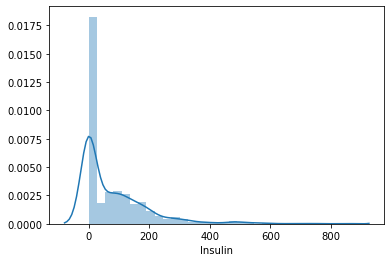

In [17]:
sns.distplot(df['Insulin'])

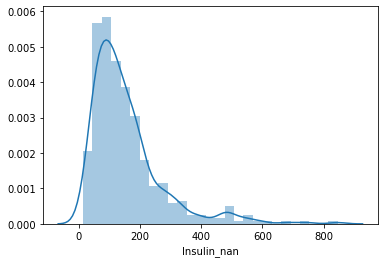

In [18]:
sns.distplot(df.loc[df['Insulin']>0, 'Insulin_nan'])

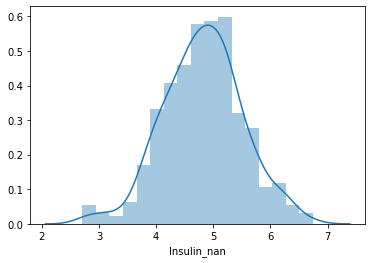

In [19]:
# 로그변환을 하면 1이하의 값에서 마이너스 무한대로 수렴하기 때문에 1을 더해준다.
# 정규분포일 때 알고리즘 성능이 더 좋아진다.

sns.distplot(np.log(df.loc[df['Insulin']>0, 'Insulin_nan']+1))

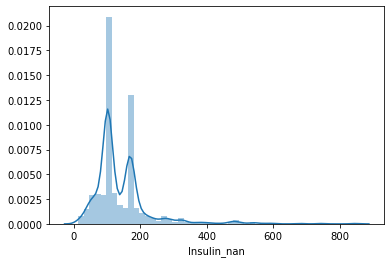

In [20]:
sns.distplot(df['Insulin_nan'])

임의로 중앙값을 채워줘서 분포에서 뾰족한 것이 하나 더 있다.

### 파생변수 만들기

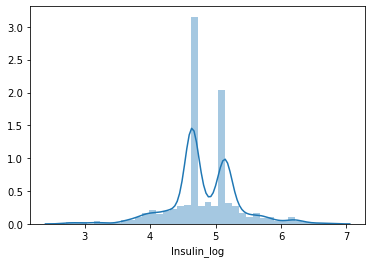

In [21]:
df['Insulin_log'] = np.log(df['Insulin_nan']+1)
sns.distplot(df['Insulin_log'])

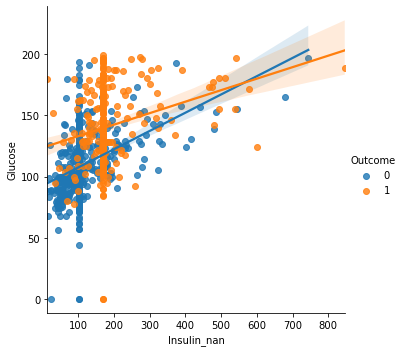

In [22]:
sns.lmplot(data=df, x='Insulin_nan', y='Glucose', hue='Outcome')

한 줄로 있는 값은 값은 결측치를 대체했기 때문이다.

In [23]:
df['low_glu_insulin'] = (df['Glucose']<100) & (df['Insulin_nan']<=102.5) 
df['low_glu_insulin'].head()

0    False
1     True
2    False
3     True
4    False
Name: low_glu_insulin, dtype: bool

In [24]:
pd.crosstab(df['Outcome'], df['low_glu_insulin'])

low_glu_insulin,False,True
Outcome,,
0,332,168
1,263,5


pd.crosstab()은 범주형 값에 대한 cross table을 그려준다.

포도당과 인슐린 수치가 낮을 때 발병횟수가 적다.

### 이상치 다루기

[상자 수염 그림](https://ko.wikipedia.org/wiki/%EC%83%81%EC%9E%90_%EC%88%98%EC%97%BC_%EA%B7%B8%EB%A6%BC)은 이상치를 확인할 때 많이 사용한다.

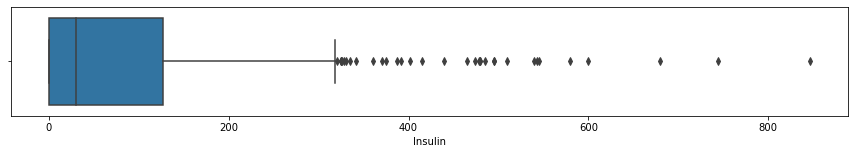

In [25]:
plt.figure(figsize=(15,2))
sns.boxplot(df['Insulin'])

결측치를 처리하지 않아서 0에 몰려있는 것으로 보인다.

박스의 가운데 선은 중앙값의 위치를 표시한다.

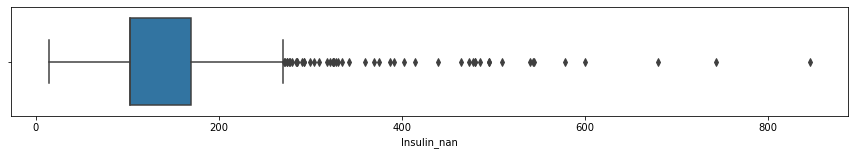

In [26]:
plt.figure(figsize=(15,2))
sns.boxplot(df['Insulin_nan'])

In [27]:
df['Insulin_nan'].describe()

count    768.000000
mean     141.753906
std       89.100847
min       14.000000
25%      102.500000
50%      102.500000
75%      169.500000
max      846.000000
Name: Insulin_nan, dtype: float64

중앙값으로 값을 대체해서 25%와 50%가 같다. max와 75% 차이가 크다.

In [28]:
# IQR 값 구하기 : 3사분위 수
IQR3 = df['Insulin_nan'].quantile(q=0.75)
IQR1 = df['Insulin_nan'].quantile(q=0.25)
IQR = IQR3-IQR1
IQR

67.0

In [29]:
OUT= IQR3 + (IQR*1.5)
OUT

270.0

In [30]:
df[df['Insulin_nan']>OUT].shape

(51, 16)

전체 데이터에서 51개 제거하면 너무 많이 제거하는 것 같아서 인슐린이 600이상 되는 자료들을 학습 데이터셋에서 제거하고자 한다.

In [31]:
df[df['Insulin_nan']>600].shape

(3, 16)

### Feature Scaling

수치 차이가 커서 수치 범위가 넓은 경우 standard scaler를 적용할 수 있다.

In [32]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Pregnancies_high,Age_low,Age_mid,Age_high,Insulin_nan,Insulin_log,low_glu_insulin
0,6,148,72,35,0,33.6,0.627,50,1,False,False,True,False,169.5,5.138735,False
1,1,85,66,29,0,26.6,0.351,31,0,False,False,True,False,102.5,4.639572,True
2,8,183,64,0,0,23.3,0.672,32,1,True,False,True,False,169.5,5.138735,False
3,1,89,66,23,94,28.1,0.167,21,0,False,True,False,False,94.0,4.553877,True
4,0,137,40,35,168,43.1,2.288,33,1,False,False,True,False,168.0,5.129899,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0,True,False,False,True,180.0,5.198497,False
764,2,122,70,27,0,36.8,0.340,27,0,False,True,False,False,102.5,4.639572,False
765,5,121,72,23,112,26.2,0.245,30,0,False,False,True,False,112.0,4.727388,False
766,1,126,60,0,0,30.1,0.349,47,1,False,False,True,False,169.5,5.138735,False


In [33]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# scaler.fit(df[['Glucose', 'DiabetesPedigreeFunction']])
# scale = scaler.transform(df[['Glucose', 'DiabetesPedigreeFunction']])
# scale

array([[ 0.84832379,  0.46849198],
       [-1.12339636, -0.36506078],
       [ 1.94372388,  0.60439732],
       ...,
       [ 0.00330087, -0.68519336],
       [ 0.1597866 , -0.37110101],
       [-0.8730192 , -0.47378505]])

In [34]:
# df[['Glucose', 'DiabetesPedigreeFunction']] = scale
# df[['Glucose', 'DiabetesPedigreeFunction']].head()

,Glucose,DiabetesPedigreeFunction
0,0.848324,0.468492
1,-1.123396,-0.365061
2,1.943724,0.604397
3,-0.998208,-0.920763
4,0.504055,5.484909


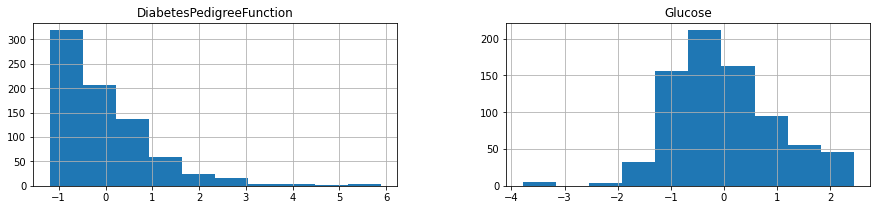

In [36]:
# h = df[['Glucose', 'DiabetesPedigreeFunction']].hist(figsize=(15,3))

In [64]:
# csv 파일로 저장하기
df.to_csv('data/diabetes_feature.csv', index=False)

In [65]:
pd.read_csv('data/diabetes_feature.csv').head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Pregnancies_high,Age_low,Age_mid,Age_high,Insulin_nan,Insulin_log,low_glu_insulin
0,6,0.848324,72,35,0,33.6,0.468492,50,1,False,False,True,False,169.5,5.138735,False
1,1,-1.123396,66,29,0,26.6,-0.365061,31,0,False,False,True,False,102.5,4.639572,True
2,8,1.943724,64,0,0,23.3,0.604397,32,1,True,False,True,False,169.5,5.138735,False
3,1,-0.998208,66,23,94,28.1,-0.920763,21,0,False,True,False,False,94.0,4.553877,True
4,0,0.504055,40,35,168,43.1,5.484909,33,1,False,False,True,False,168.0,5.129899,False


## 학습 데이터셋 나누기

In [37]:
# 전체 데이터의 행에서 80% 위치에 해당하는 값을 splict_count 변수에 담는다.
split_count = int(df.shape[0]*0.8)
split_count

614

In [38]:
# 0 ~ 613행 명시적 복사
train = df[:split_count].copy()
train.shape

(614, 16)

In [39]:
train[train['Insulin_nan']<600].shape

(610, 16)

학습 데이터셋에 이상치가 전부 있다.

In [40]:
train = train[train['Insulin_nan']<600]
train.shape

(610, 16)

## 예측 데이터셋 나누기

In [41]:
test = df[split_count:].copy()
test.shape

(154, 16)

## 학습과 예측에 사용할 컬럼

In [42]:
# 학습에 사용할 컬럼
feature_names = train.columns.tolist()
feature_names.remove('Pregnancies')
feature_names.remove('Outcome')
feature_names.remove('Age_low')
feature_names.remove('Age_mid')
feature_names.remove('Age_high')
feature_names.remove('Insulin')
feature_names.remove('Insulin_log')
feature_names

['Glucose',
 'BloodPressure',
 'SkinThickness',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age',
 'Pregnancies_high',
 'Insulin_nan',
 'low_glu_insulin']

## 정답이자 예측해야 될 값

In [43]:
# 정답 컬럼
label_names = 'Outcome'
label_names

'Outcome'

## 학습, 예측 데이터셋 만들기

In [44]:
# 학습 세트 만들기 예:시험의 기출문제
X_train = train[feature_names]
print(X_train.shape)
X_train.head()

(610, 9)


,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Pregnancies_high,Insulin_nan,low_glu_insulin
0,0.848324,72,35,33.6,0.468492,50,False,169.5,False
1,-1.123396,66,29,26.6,-0.365061,31,False,102.5,True
2,1.943724,64,0,23.3,0.604397,32,True,169.5,False
3,-0.998208,66,23,28.1,-0.920763,21,False,94.0,True
4,0.504055,40,35,43.1,5.484909,33,False,168.0,False


Pregnancies_high의 값은 Boolean 값인데 이는 결정트리 알고리즘에 사용가능하다.

In [45]:
# 정답 값을 만든다. 예:기출문제의 정답
y_train = train[label_names]
print(y_train.shape)
y_train.head()

(610,)


0    1
1    0
2    1
3    0
4    1
Name: Outcome, dtype: int64

In [46]:
# 예측에 사용할 데이터 세트를 만든다 예:실전 시험문제
X_test = test[feature_names]
print(X_test.shape)
X_test.head()

(154, 9)


,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Pregnancies_high,Insulin_nan,low_glu_insulin
614,0.535352,74,26,36.1,0.257084,50,True,144.0,False
615,-0.466156,72,0,25.8,-0.799958,27,False,102.5,False
616,-0.121888,96,0,28.7,-0.950964,30,False,102.5,False
617,-1.655448,62,13,20.1,-0.648952,23,False,15.0,True
618,-0.278373,82,24,28.2,2.446670,50,True,169.5,False


In [47]:
# 예측의 정답값 예:실전 시험문제의 정답
y_test = test[label_names]
print(y_test.shape)
y_test.head()

(154,)


614    1
615    0
616    0
617    0
618    1
Name: Outcome, dtype: int64

## 머신러닝 알고리즘 가져오기

In [48]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
# model?

## 학습(훈련)

In [49]:
# ? 도움말 화면
# shift + tab : 옵션 확인 가능
model.fit(X_train, y_train)

DecisionTreeClassifier()

## 예측

정답을 직접 예측한다.

In [50]:
y_predict = model.predict(X_test)
y_predict[:5]

array([1, 0, 0, 0, 1], dtype=int64)

## 트리 알고리즘 분석하기
- 의사결정나무를 시각화해보자.

[Text(183.52968750000002, 209.07692307692307, 'Insulin_nan <= 143.5\ngini = 0.453\nsamples = 610\nvalue = [399, 211]'),
 Text(110.43750000000001, 192.35076923076923, 'Insulin_nan <= 109.0\ngini = 0.163\nsamples = 380\nvalue = [346, 34]'),
 Text(83.7, 175.62461538461537, 'BMI <= 49.95\ngini = 0.098\nsamples = 329\nvalue = [312, 17]'),
 Text(79.05000000000001, 158.89846153846153, 'Glucose <= 0.958\ngini = 0.082\nsamples = 326\nvalue = [312, 14]'),
 Text(67.42500000000001, 142.1723076923077, 'Insulin_nan <= 99.5\ngini = 0.062\nsamples = 312\nvalue = [302, 10]'),
 Text(62.775000000000006, 125.44615384615385, 'Insulin_nan <= 95.5\ngini = 0.154\nsamples = 119\nvalue = [109, 10]'),
 Text(58.12500000000001, 108.72, 'BloodPressure <= 83.0\ngini = 0.127\nsamples = 117\nvalue = [109, 8]'),
 Text(37.2, 91.99384615384615, 'DiabetesPedigreeFunction <= 0.621\ngini = 0.088\nsamples = 108\nvalue = [103, 5]'),
 Text(18.6, 75.2676923076923, 'SkinThickness <= 31.5\ngini = 0.044\nsamples = 89\nvalue = [87,

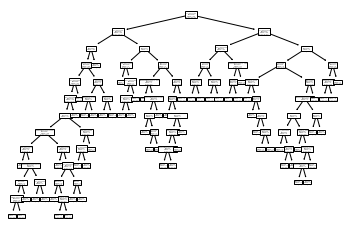

In [51]:
from sklearn.tree import plot_tree

plot_tree(model, feature_names=feature_names)

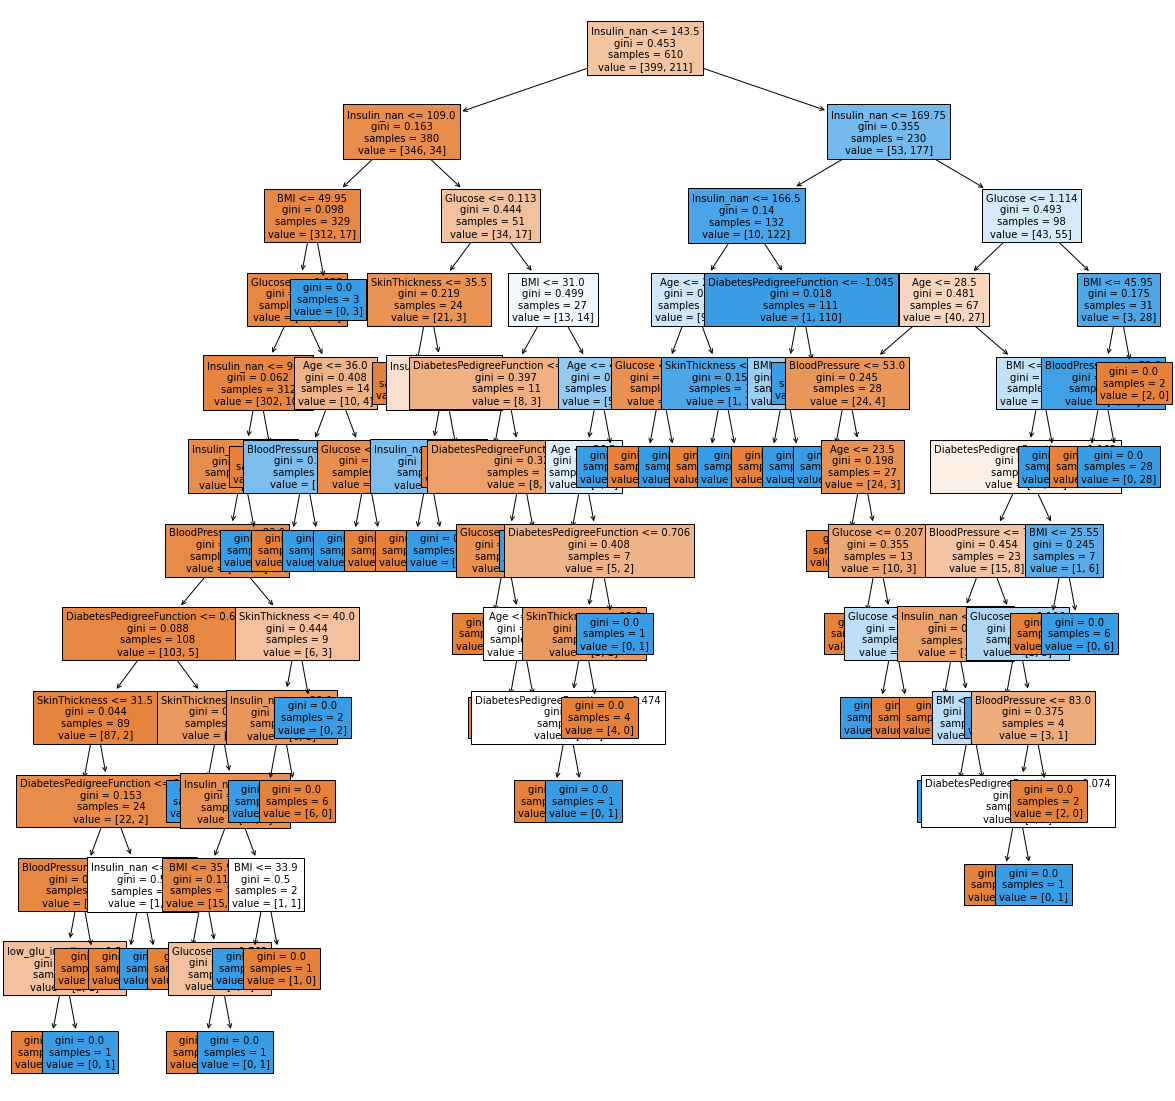

In [52]:
plt.figure(figsize=(20,20))
tree = plot_tree(model, feature_names=feature_names, filled=True, fontsize=10)

In [53]:
# import graphviz
# from sklearn.tree import export_graphviz

# dot_tree = export_graphviz(model, feature_names=feature_names, filled=True)
# graphviz.Source(dot_tree)

In [54]:
# 피처의 중요도를 추출하기
model.feature_importances_

array([0.10441235, 0.03363528, 0.03024193, 0.08008031, 0.03818837,
       0.07729088, 0.        , 0.63132048, 0.0048304 ])

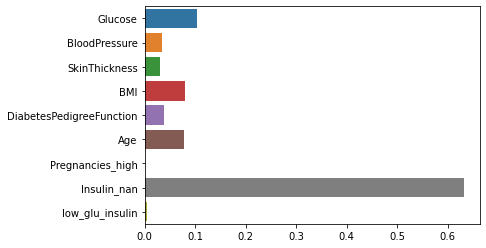

In [55]:
# 피처의 중요도 시각화하기
sns.barplot(x=model.feature_importances_, y=feature_names)

포도당이 가장 중요한 특징이다. 

Pregnancies_high는 중요한 특징이 아니고 오버피팅을 야기할 수 있다.

low_glu_insulin는 큰 영향을 가지지 않은 것으로 보인다.

## 정확도(Accuracy) 측정하기

In [56]:
# 다르게 예측한 개수
diff_count = abs(y_test - y_predict).sum()
diff_count

21

In [57]:
# 다르게 예측한 비율
diff_ratio = abs(y_test - y_predict).sum() / len(y_test)
diff_ratio

0.13636363636363635

In [58]:
# 예측의 정확도를 구한다.
print(1 - diff_ratio)
print((len(y_test)-diff_count)/len(y_test))

0.8636363636363636
0.8636363636363636


In [59]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_predict)*100

86.36363636363636

In [60]:
model.score(X_test, y_test)*100

86.36363636363636

Age를 범주화하면 예측 성능이 더 안 좋아졌다.
- 피처 엔지니어링이 반드시 성능을 향상시키지 않는다.

인슐린 결측치를 중앙값으로 대체했을 때 예측 성능이 가장 좋아졌다.
- 연령대별 인슐린 수치로 대체하는 것도 한 가지 방법이다.
- 포도당 수치와 발병유무를 고려해 결측치를 대체할 수 있다.
- 결측치가 많으면 제거하지 않고 임의의 값으로 대체하면 예측 성능이 좋아진다.

로그변환을 했으나 큰 성능 향상을 보이지 않는다.

포도당과 인슐린을 결합한 파생변수를 사용했을 때 다소나마 성능이 향상되었다.
- 88% : 인슐린, 글루코스의 상관계수로 파생변수를 생성 

이상치를 처리한 결과 성능 차이가 크게 발생하지 않았다.

Feature scaling을 한 결과 오차가 더 늘었다.
- 수치 차이가 적어서 성능에 영향을 주지 않은 것으로 보인다.
